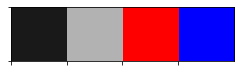

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import time

sys.setrecursionlimit(10000)

%matplotlib inline
init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

np.random.seed(1234)
directory = os.path.join("..", "data", "MDC") 


def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    matplotlib.rc("font", family="Times New Roman")

    
def get_colors():
    return np.array([
        [0.1, 0.1, 0.1],          # black
        # [0.4, 0.4, 0.4],          # very dark gray
        [0.7, 0.7, 0.7],          # dark gray
        # [0.9, 0.9, 0.9],          # light gray
        'red',                     
        'blue'
    ])
        
        
def set_size(fig, w=6, h=3):
    fig.set_size_inches(w, h)
    plt.tight_layout()

    
sns.palplot(get_colors())

# Visits

In [2]:
### get parcels from OpenStreetMaps

# import geocoder
# from time import sleep


# def get_parcel(lat, lon):
#     g = geocoder.osm([lat, lon], method='reverse')
#     return g.geojson.get("features")[0].get("properties").get("place_id")
# get_parcel(46.530000, 6.570000)  # test

# visits = pd.read_csv(os.path.join(directory, "visits.csv"))
# locations = pd.read_csv(os.path.join(directory, 'locations_complete.csv'))
# visits = pd.merge(visits, locations, how='left', on=['lat', 'lon'])
# visits = visits.drop(columns='ct')
# visits.to_csv(os.path.join(directory, "visits_with_locs.csv"), index=False)

In [3]:
# EVENT DATA COUNTS
events = pd.read_csv(os.path.join(directory, "events.csv"))
print("Events:", events.shape[0])
print("Users:", events.user_id.nunique())
print("Avg:", round(events.shape[0] / events.user_id.nunique(), 1))

Events: 474110
Users: 186
Avg: 2549.0


In [4]:
# VISIT DATA COUNTS
visits = pd.read_csv(os.path.join(directory, "visits_with_locs.csv"))
print("Visits:", visits.shape[0])
print("Users:", visits.user_id.nunique())
print("Avg:", round(visits.shape[0] / visits.user_id.nunique(), 1))

Visits: 462303
Users: 186
Avg: 2485.5


In [5]:
# DURATION OF OBSERVATION
print(pd.to_datetime(min(visits.t), unit='s'))
print(pd.to_datetime(max(visits.t), unit='s'))
print("Duration: {} days".format(max(visits.day_id)+1))  # zero indexed

2009-09-01 05:16:09
2011-03-31 21:29:31
Duration: 577 days


# Distn of visits over time

In [6]:
visits['dt'] = pd.to_datetime(visits.t, unit='s')
visits.head()

,key,user_id,t,lat,lon,type,src,visit,dt,day_id,location_id
0,242003874,5578.0,1.251782e+09,46.530000,6.570000,app,wlan,0,2009-09-01 05:16:09,0,58329420
1,78685776,5980.0,1.251786e+09,46.522046,6.646996,app,gps,0,2009-09-01 06:26:35,0,100176532
2,78685790,6033.0,1.251786e+09,46.521647,6.640392,app,gps,0,2009-09-01 06:28:18,0,203282893
3,78685802,5966.0,1.251787e+09,46.524642,6.636998,sms.d,gps,0,2009-09-01 06:29:37,0,199210838
4,78685808,5927.0,1.251787e+09,46.520000,6.635000,app,gps,0,2009-09-01 06:30:17,0,100568957


In [7]:
test = visits.set_index(['dt'])
month_cts = test.groupby(pd.Grouper(freq='M'))['visit'].count()
month_cts

dt
2009-09-30     9324
2009-10-31    28203
2009-11-30    37463
2009-12-31    30411
2010-01-31    41084
2010-02-28    38975
2010-03-31    41752
2010-04-30    50262
2010-05-31    46345
2010-06-30    45163
2010-07-31    17808
2010-08-31    12653
2010-09-30    11589
2010-10-31    12223
2010-11-30    10082
2010-12-31     8956
2011-01-31     7663
2011-02-28     6304
2011-03-31     6043
Freq: M, Name: visit, dtype: int64

# Distn of locations

In [8]:
# location weights based on number of visits
locs = visits.groupby('location_id')['key'].count()
wt_e = pd.DataFrame(locs).reset_index().rename(columns={'key': 'weight'})
wt_e['weight'] = 1 / wt_e['weight']

# location weights based on number of unique users at location
locs_users = visits.groupby(['location_id'])['user_id'].nunique()
wt_u = pd.DataFrame(locs_users).reset_index().rename(columns={'user_id': 'weight'})
wt_u['weight'] = 1 / wt_u['weight']

# merge weights in to the point pattern data
visits = pd.merge(visits, wt_e, on='location_id')
visits = pd.merge(visits, wt_u, on='location_id', suffixes=('_event', '_user'))

visits.head()

,key,user_id,t,lat,lon,type,src,visit,dt,day_id,location_id,weight_event,weight_user
0,242003874,5578.0,1.251782e+09,46.53,6.57,app,wlan,0,2009-09-01 05:16:09,0,58329420,0.000083,0.005435
1,213025584,5462.0,1.251809e+09,46.53,6.57,media_play,wlan,4,2009-09-01 12:44:45,0,58329420,0.000083,0.005435
2,193956041,5542.0,1.251839e+09,46.53,6.57,app,wlan,10,2009-09-01 21:08:24,0,58329420,0.000083,0.005435
3,128872069,5477.0,1.251887e+09,46.53,6.57,app,wlan,16,2009-09-02 10:28:13,1,58329420,0.000083,0.005435
4,247474790,5477.0,1.252079e+09,46.53,6.57,app,wlan,29,2009-09-04 15:46:14,3,58329420,0.000083,0.005435


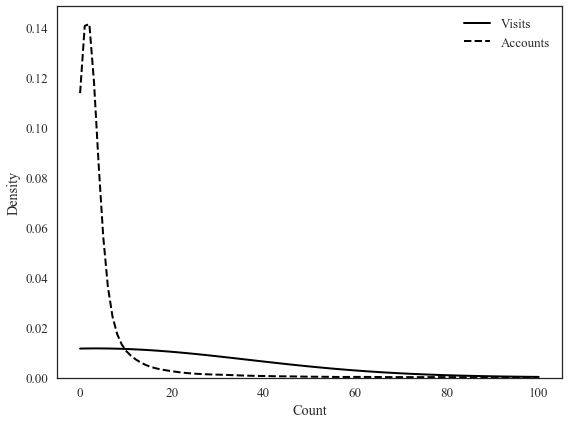

In [9]:
set_style()

f, ax = plt.subplots()

ax = sns.kdeplot(
    locs, 
    color = 'black',
    lw=2,
    clip=(0,100),
    label='Visits'
)
ax = sns.kdeplot(
    locs_users, 
    color = 'black',
    linestyle = 'dashed',
    lw=2,
    clip=(0,100),
    label='Accounts'
)
ax.set(ylabel="Density")
ax.set(xlabel="Count")

set_size(f, 8, 6)

plt.show()

In [10]:
locs.head()

location_id
103756    10
104145    29
105224    12
105234     7
105249     1
Name: key, dtype: int64

In [11]:
locs.describe()

count    31534.000000
mean        14.660462
std        260.222601
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max      24948.000000
Name: key, dtype: float64

In [12]:
locs_users.describe()

count    31534.000000
mean         5.739297
std         16.140035
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        184.000000
Name: user_id, dtype: float64

In [13]:
common_locs = locs_users.loc[locs_users > 140].index  # locations with >75% of users visiting
common_locs

Int64Index([  4114414,  21430867,  25335214,  33697810,  38448853,  42423687,
             43651967,  46449053,  46867364,  50904698,
            ...
            188418020, 191393941, 201351653, 205110379, 206644109, 221544107,
            235667325, 236023081, 278627411, 283890119],
           dtype='int64', name='location_id', length=121)

In [14]:
locs[common_locs].describe()

count      121.000000
mean      2058.735537
std       3658.435533
min        382.000000
25%        598.000000
50%        850.000000
75%       1710.000000
max      24948.000000
Name: key, dtype: float64

In [15]:
sum(locs[common_locs])

249107

In [16]:
locs.loc[locs == locs.max()]

location_id
151915032    24948
Name: key, dtype: int64

In [17]:
visits.loc[visits.location_id == 151915032, ['lat', 'lon']].describe()

,lat,lon
count,24948.00,2.494800e+04
mean,46.51,6.560000e+00
std,0.00,1.776392e-15
min,46.51,6.560000e+00
25%,46.51,6.560000e+00
50%,46.51,6.560000e+00
75%,46.51,6.560000e+00
max,46.51,6.560000e+00


In [18]:
locs_users[151915032]

183

# Look at factor variables

In [19]:
sum(visits.src == 'gps') / len(visits)

0.4703452064987681

In [20]:
visits.groupby('type')['key'].count() / len(visits)

type
app           0.938856
call_log      0.019634
call_log.d    0.007523
media_play    0.016632
sms           0.009632
sms.d         0.007722
Name: key, dtype: float64

In [64]:
visits_thin = visits.loc[~visits.location_id.isin(common_locs)]
visits_thin.to_csv(os.path.join(directory, 'visits_thinned.csv'), index=False)
sum(visits_thin.src == 'gps') / len(visits_thin)

0.6537458488902231

In [22]:
visits_thin.groupby('type')['key'].count() / len(visits_thin)

type
app           0.938883
call_log      0.019447
call_log.d    0.007495
media_play    0.016937
sms           0.009630
sms.d         0.007608
Name: key, dtype: float64

# Create MPP

In [23]:
### A == March 2011; B == Feb 2011
a_start = '2011-03-01'
a_end = '2011-04-01'    
b_start = '2011-02-01'
b_end = '2011-03-01'

a = visits_thin.loc[(visits.dt >= a_start) & (visits.dt <= a_end)]
b = visits_thin.loc[(visits.dt >= b_start) & (visits.dt <= b_end)]

In [24]:
common_users = np.intersect1d(a.user_id.unique(), b.user_id.unique())
a = a.loc[a.user_id.isin(common_users)]
b = b.loc[b.user_id.isin(common_users)]

In [25]:
### A
print("Obs days:", a.day_id.nunique())
print("Visits:", len(a))
print("Users:", a.user_id.nunique())
print("Avg:", round(len(a)/a.user_id.nunique(), 1))

Obs days: 31
Visits: 1769
Users: 54
Avg: 32.8


In [26]:
### B
print("Obs days:", b.day_id.nunique())
print("Visits:", len(b))
print("Users:", b.user_id.nunique())
print("Avg:", round(len(b)/b.user_id.nunique(), 1))

Obs days: 28
Visits: 1797
Users: 54
Avg: 33.3


In [27]:
### create mpp data frame
keep_cols = ["key", "user_id", "lat", "lon", "m", 'location_id']
a['m'] = 'a'
b['m'] = 'b'
mpp = pd.concat([a[keep_cols], b[keep_cols]])
mpp = mpp.rename(columns={"user_id": "uid"})
mpp.head()

,key,uid,lat,lon,m,location_id
19057,135340457,6076.0,46.513567,6.639270,a,99736484
19058,231687374,5477.0,46.513772,6.639211,a,99736484
19059,135342671,6192.0,46.513583,6.639255,a,99736484
19060,136587465,5959.0,46.513567,6.639270,a,99736484
19061,213415069,6189.0,46.513674,6.639306,a,99736484


In [28]:
# merge weights in to the point pattern data
mpp = pd.merge(mpp, wt_e, on='location_id')
mpp = pd.merge(mpp, wt_u, on='location_id', suffixes=('_event', '_user'))
mpp.to_csv(os.path.join(directory, "mpp_marchA_febB.csv"), index=False)
mpp.head()

,key,uid,lat,lon,m,location_id,weight_event,weight_user
0,135340457,6076.0,46.513567,6.639270,a,99736484,0.005291,0.010309
1,231687374,5477.0,46.513772,6.639211,a,99736484,0.005291,0.010309
2,135342671,6192.0,46.513583,6.639255,a,99736484,0.005291,0.010309
3,136587465,5959.0,46.513567,6.639270,a,99736484,0.005291,0.010309
4,213415069,6189.0,46.513674,6.639306,a,99736484,0.005291,0.010309


# Plot some examples

In [85]:
import branca.colormap as cm
from branca.element import Template, MacroElement
from collections import defaultdict
import folium
from folium.plugins import HeatMap, MarkerCluster

### https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:24px; left: 20px; bottom: 40px;'>
     
<div class='legend-title'></div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;'></span>A</li>
    <li><span style='background:red;'></span>B</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 10px;
    width: 10px;
    -webkit-border-radius: 5px;
    -moz-border-radius: 5px;
    border-radius: 5px;
    margin-right: 5px;
    margin-left: 0;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


def calc_freqs(df):
    ### grid the population data for OC & count visits in each bin
    data = df.copy()
    data["lat_r"] = data.lat.round(3)
    data["lon_r"] = data.lon.round(3)
    freqs = (
        data.groupby(["lat_r", "lon_r"]).count().reset_index()[["lat_r", "lon_r", "key"]]
    )
    freqs.columns = ["lat_r", "lon_r", "freq"]
    return freqs


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def make_user_scatter_plot(mpp, uid, mark):
    user = get_user(mpp, uid, mark)
    return list(zip(user.lat, user.lon))


def plot_heat_and_scatter(mpp, uid, freqs=None, uidB=None, heat=False):
    if uidB is None:
        uidB = uid
    if heat:
        col = 'lightgreen'
        opacity = 0.8
    else:
        col = 'red'
        opacity = 0.75
    
    ### make the map
    hmap = folium.Map(
        location=[46.8, 8.09],
#         location=[46.53, 6.63],
        width='100%', 
        zoom_start=8,
#         zoom_start=12,
        zoom_control=False,
        tiles='CartoDB positron',
    )
    
    ### make the heatmap
    if heat:
        steps = 20
        color_map = cm.linear.YlOrRd_09.scale(0, 1).to_step(steps)

        gradient_map = defaultdict(dict)
        for i in range(steps):
            gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)

        heat = HeatMap( 
            data=list(zip(freqs['lat_r'], freqs['lon_r'], freqs['freq'])),
            min_opacity=0.2,
            max_val=float(freqs['freq'].max()),
            radius=25, 
            blur=16, 
            max_zoom=5, 
            gradient=gradient_map
        )
        
        hmap.add_child(heat)
        hmap.add_child(color_map)

    ### make the scatters
    f = folium.map.FeatureGroup()
    for pt in make_user_scatter_plot(mpp, uid, 'a'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color='black',
                fill_opacity=0.75)
        )

    for pt in make_user_scatter_plot(mpp, uidB, 'b'):
        f.add_child(
            folium.vector_layers.CircleMarker(
                pt,
                radius=4,
                color=None,
                fill_color=col,
                fill_opacity=opacity)
        )
    hmap.add_child(f)

    ### add legend
    macro = MacroElement()
    macro._template = Template(template)
    hmap.get_root().add_child(macro)

    return hmap


def map_to_png(m, filename):
    fn='figs/tempmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    m.save(fn)

    driver = webdriver.Chrome()
    # driver.set_window_size(400, 300)  # choose a resolution
    driver.get(tmpurl)

    time.sleep(5)  # give the map tiles some time to load
    driver.save_screenshot(filename)
    driver.quit()
    

In [86]:
from IPython import display

users = mpp.uid.unique()
for u in users:
    m = plot_heat_and_scatter(
        mpp=mpp, 
        uid=u, 
    )
    display.clear_output(wait=True)
    display.display(m)
    time.sleep(1.5)

# Population KDE

In [31]:
### conversion factors
latitude = 40.74

e = 0.00669437999014
a = 6378.137
lat_to_km = round(1 / ((np.pi*a*(1-e))/ (180*(1-e*(np.sin(latitude))**2)**(3/2))), 6)
lon_to_km =  round(1 / (np.cos(latitude*np.pi/180)*111.321), 6)
print('latitude:', 1 / lat_to_km)
print('longitude:', 1 / lon_to_km)

latitude: 0.009043
longitude: 0.011856


In [32]:
from kde.location_project.kde_2d import (
    KDE,
    MixtureKDE,
    create_individual_component_data,
    learn_nearest_neighbors_bandwidth
)

# learn the bandwidth for each point & save to file (it's expensive)
filepath = os.path.join(directory, "population_visits_kde_data.npy")

# points = visits_thin.loc[:, ['lon', 'lat']].values
# bw_pop = learn_nearest_neighbors_bandwidth(points, lon_to_km=lon_to_km, lat_to_km=lat_to_km, k=5, min_bw=0.05)
# kde_data = np.hstack([points, np.atleast_2d(bw_pop).T])  # adaptive bandwidth
# kde_data = np.append(kde_data, np.ones((len(kde_data), 1)), 1)  # equal weights by default
# np.save(filepath, kde_data)

pop_kde_data = np.load(filepath)
pop_kde_data.shape

(213196, 4)

In [101]:
# create the population KDE
pop_kde = KDE(pop_kde_data)

# # create the individual KDE
# ind_A = (oc_mpp.uid == uA) & (oc_mpp.m == 'a')
# indiv_kde_data = create_individual_component_data(oc_mpp.loc[ind_A, ])
# indiv_kde = KDE(indiv_kde_data)

# # create the mixture KDE
# mix_kde = MixtureKDE(indiv_kde_data, pop_kde_data)


def eval_density(kde, xlim=[-118.2, -117.5], ylim=[33.4, 34], delta = 0.01):  # oc defaults
    x = np.arange(xlim[0], xlim[1], delta)  # longitude
    y = np.arange(ylim[0], ylim[1], delta)  # latitude
    X, Y = np.meshgrid(x, y)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    z = np.apply_along_axis(kde.log_pdf, 1, pts)
    Z = np.reshape(z, X.shape)
    return X, Y, Z

xlim = [5.88, 10.5]
ylim = [45.8, 47.82] 
delta = 0.01
# X_i, Y_i, Z_i = eval_density(indiv_kde, xlim=xlim, ylim=ylim, delta=delta)
X_p, Y_p, Z_p = eval_density(pop_kde, xlim=xlim, ylim=ylim, delta=delta)
# X_m, Y_m, Z_m = eval_density(mix_kde, xlim=xlim, ylim=ylim, delta=delta)

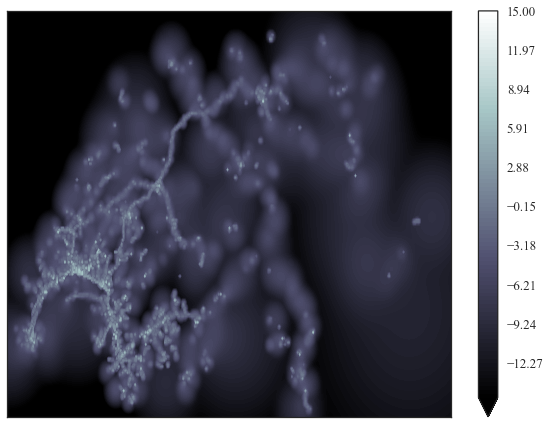

In [102]:
set_style()

f, ax = plt.subplots()

plt.contourf(
    X_p, Y_p, Z_p, 
    levels=np.linspace(-15,15,100),
    cmap='bone',
    extend='min',
)
plt.colorbar()

plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('')

set_size(f, 8, 6)

plt.show()

In [103]:
freqs = calc_freqs(visits_thin)
m = plot_heat_and_scatter(
    freqs=freqs, 
    mpp=mpp, 
    uid=None, 
    heat=True
)
m

In [104]:
Z = (Z_p - np.min(Z_p)) / (np.max(Z_p) - np.min(Z_p))
out = pd.DataFrame(np.stack([X_p.ravel(), Y_p.ravel(), np.exp(Z_p.ravel()), Z.ravel()], axis=1))
out = out.rename(columns={0:'lon', 1:'lat', 2:'pdf', 3:'scaled_pdf'})
out.to_csv(os.path.join(directory, 'population_kde_grid.csv'), index=False)
out.head()

,lon,lat,pdf,scaled_pdf
0,5.88,45.8,7.477831e-08,0.639261
1,5.89,45.8,7.547036e-08,0.639400
2,5.90,45.8,7.570922e-08,0.639448
3,5.91,45.8,7.549049e-08,0.639404
4,5.92,45.8,7.481808e-08,0.639269


# Compute Scores

In [159]:
import itertools
from emd import emd
from kde.location_project.cmp import geodesic_dist


def get_user(mpp, uid, mark):
    out = mpp.copy()
    # out = out.drop_duplicates(subset=["location_id", "m"])
    return out.loc[(out.uid == uid) & (out.m == mark)].reset_index(drop=True)


def population_scores(mpp, keeps):
    rslt = []    
    for index, row in keeps.iterrows():
        user_A = row["a"]
        user_B = row["b"]
        tmp = {}
        try:
            ### get the data for the pair in question
            tmp['a'] = user_A
            tmp['b'] = user_B
            uA = get_user(mpp, user_A, 'a')
            uB = get_user(mpp, user_B, 'b')

            ### compute weights
            uA_wt_e = (uA['weight_event'] / sum(uA['weight_event'])).to_numpy()
            uA_wt_u = (uA['weight_user'] / sum(uA['weight_user'])).to_numpy()
            uB_wt_e = (uB['weight_event'] / sum(uB['weight_event'])).to_numpy()
            uB_wt_u = (uB['weight_user'] / sum(uB['weight_user'])).to_numpy()

            ### compute the distance matrix & IED scores
            dist = geodesic_dist(uA[['lat', 'lon']], uB[['lat', 'lon']])
            ied = dist.min(1)
            tmp['ied_med'] = np.median(ied)
            tmp['ied_mn'] = np.average(ied)
            tmp['ied_mn_wt_event'] = np.average(ied, weights=uA_wt_e)
            tmp['ied_mn_wt_user'] = np.average(ied, weights=uA_wt_u)

            ### compute variants of EMD
            tmp['emd'] = emd(distance="precomputed", D=dist)
            tmp['emd_wt_event'] = emd(
                X_weights=uA_wt_e, Y_weights=uB_wt_e, distance="precomputed", D=dist
            )
            tmp['emd_wt_user'] = emd(
                X_weights=uA_wt_u, Y_weights=uB_wt_u, distance="precomputed", D=dist
            )

            ### store it
            rslt.append(tmp)
        except:
            print(f"Error! A = {user_A}, B = {user_B}")
            continue
    return pd.DataFrame(rslt)


# compute score vals for all pairwise combinations
sample = pd.DataFrame(list(itertools.product(users, users)), columns=['a', 'b'])
sample = sample.sort_values(['a', 'b'], axis=0).reset_index(drop=True)
score_vals = population_scores(mpp, sample.iloc[0:2])
score_vals.to_csv(os.path.join(directory, "score_func_vals.csv"), index=False)